### IMPORT LIBRARIES
---

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [2]:
ds1 = xr.open_dataset('../data/stratiform_cloud_histogram_20142019_all_altitudes_v1.nc')
clouds1 = ds1.cloud_amount.values
clouds1[np.where(np.isnan(clouds1))]=-1
clouds1[0,1,0,0,0]

0.0

In [3]:
savefig   = True
fig_extension = '.pdf'
cloud_bot_bound = 'all_altitudes_v1' # dmv distribution
kernl_bot_bound = 'all_altitudes_v2' # dmv distribution, reff from linear fit between reff and dmv
savename_bot_bound = 'cloud_'+cloud_bot_bound+'_krnel_'+kernl_bot_bound
sidx = 2

In [4]:
slf_str = ['0.0', '0.30' , '0.75' , '0.95' , '0.999' , '1.0']
twp_str = ['0.0', '27'   , '58'   , '105'  , '180'  , '2250' ]
dmv_str = ['0.0',' 0.026', '0.031', '0.042', '0.062', '0.145']
month_str = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
vars = ['amt','slf','twp','dmv']

slf_bounds_array = np.array([0.0, 0.3, 0.75, 0.95, 0.999, 1])
twp_bounds_array = np.array([0.0, 27, 58, 105, 180, 2250])
dmv_bounds_array = np.array([0.0, 0.026, 0.031, 0.042, 0.062, 0.145])
eff_bounds_array = np.array([0.,  2.7448,  4.1848,  7.3528, 13.1128, 37.0168]) # linear relationship
# eff_bounds = np.array([
#     [-11.7689,  -7.2746,  -2.7804,   1.7139,   6.2081,  10.7024,15.1966],
#     [-11.378 ,  -6.9957,  -2.6133,   1.7691,   6.1515,  10.5339,14.9162],
#     [-14.7847,  -8.8326,  -2.8804,   3.0717,   9.0238,  14.9759,20.928 ],
#     [-15.8087,  -9.0344,  -2.2602,   4.5141,  11.2884,  18.0626,24.8369],
#     [-17.048 ,  -8.6933,  -0.3386,   8.0161,  16.3709,  24.7256,33.0803],
#     [-16.1107,  -4.4488,   7.2131,  18.875 ,  30.5369,  42.1987,53.8606]])

bot_bounds_lin = np.array([[ 160., 1450., 2740.],[1450., 2740., 4030.]])
hgt_bounds_log = np.array([[ 538., 1499.,  509.],[1612., 3479.,  741.]])
hgt_bounds_lin = np.array([[  60.,  120.,  520.],[1650., 1240.,  800.]])

dmv_perc = np.array([0., 0.025, 0.028, 0.035, 0.050,0.081 ,0.142])

temp_anomaly = np.array(
    [
        -12.52975205, -11.12814064, -11.8650665 ,  -5.89268901,
        4.87499849,   9.59777425,  13.71441323,  12.16106015,
        10.09283294,   4.99841015,  -2.79271633, -11.23112467
        ]
    )[...,np.newaxis,np.newaxis,np.newaxis]

### FUNCTIONS
---

In [5]:
# SAVE DATA ARRAY
def make_DA(data,longname,units,dims,coords,description):
    da = xr.DataArray(
        data=data,
        dims=dims,
        coords=coords,
        attrs=dict(
            long_name=longname,
            description=description,
            units=units,
        ),)
    return da

# LINE OF BEST FIT
def lbf(x,y):
    coef, __, __, __, __ = np.polyfit(x, y, 1, full=True)
    y_fit = coef[0]*x+coef[1]
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return(y_fit,coef[0],'y='+str(np.round(coef[0],4))+'x+'+str(np.round(coef[1],4)),str(np.round(r2,3)))

# PROCESS DATA STATISTICS
def dataset_stats(ds):
    # monthly mean
    ds_monthly = ds.resample(time='MS').mean("time")
    # climatology
    ds_climo = ds_monthly.groupby("time.month").mean("time")
    # monthly anomalies
    ds_anom  = ds_monthly.groupby("time.month") - ds_climo
    # standard score
    climatology_avg = ds_monthly.groupby("time.month").mean("time")
    climatology_std = ds_monthly.groupby("time.month").std("time")
    ds_std_anom = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        ds_monthly.groupby("time.month"),
        climatology_avg,
        climatology_std,
    )
    ds_std_monthly = xr.apply_ufunc(
        lambda x, s: x / s,
        ds_monthly.groupby("time.month"),
        climatology_std,
    )
    # month numbers
    ds['months']=ds_monthly.time.dt.month
    ds_anom['months'] = ds_anom.time.dt.month
    ds_std_anom['months'] = ds_std_anom.time.dt.month
    # drop month
    ds_anom = ds_anom.drop('month')
    ds_std_anom = ds_std_anom.drop('month')
    return(ds_climo,ds_anom,ds_std_anom,ds_monthly,ds_std_monthly)

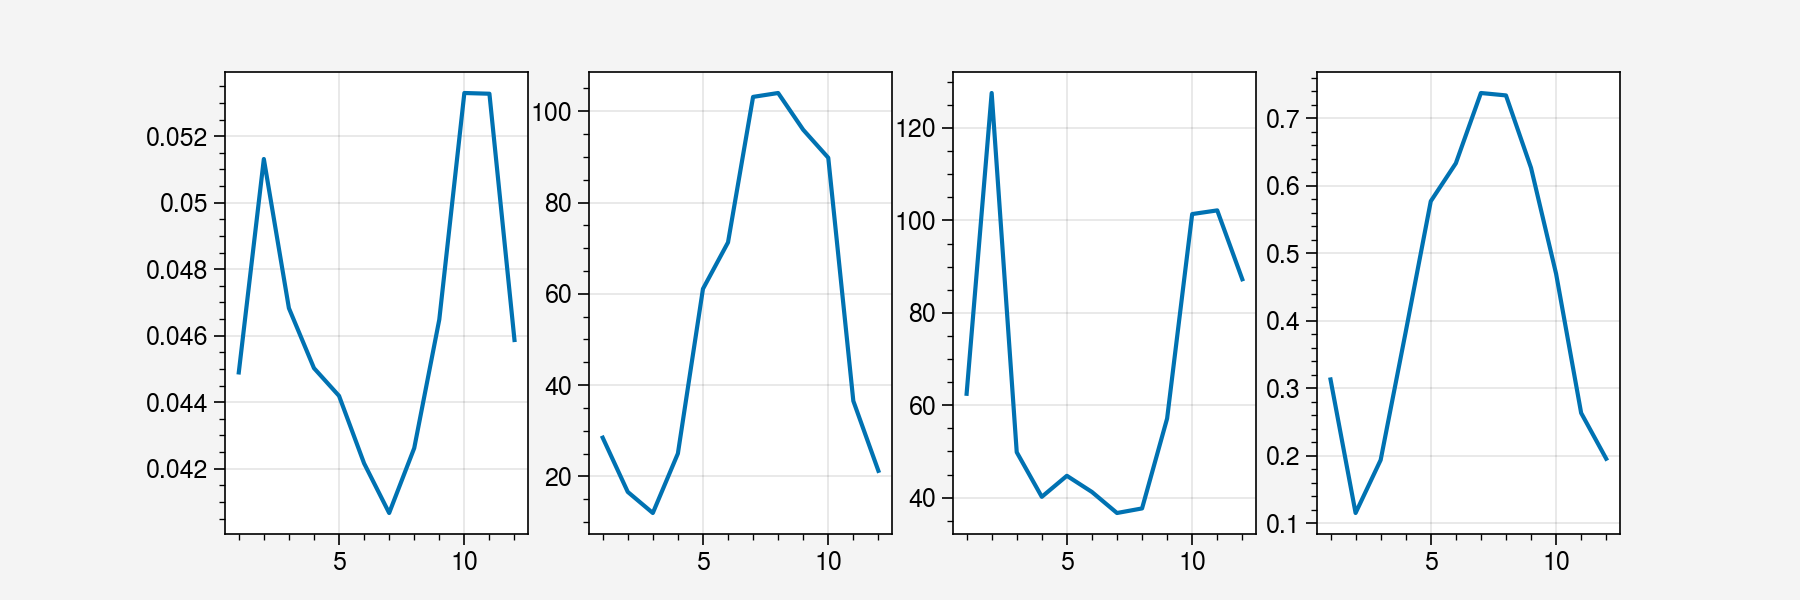

In [6]:
ds = xr.open_dataset('../data/DOE_ARM_NSA_cloud_dataset_20002020.nc')
# time  = pd.to_datetime(ds.time.values)
# dmv = ds.dmv_avg_gcpex.values
# iwp = ds.iwp_avg5km.values
# lwp = ds.lwp_avg5km.values
# ice = ds.rice_avg5km.values
# liq = ds.rliq_avg5km.values
# cbot_armb = ds.cbot_armb.values
# ctop_armb = ds.ctop_armb.values
# chgt_armb = ctop_armb-cbot_armb
# msk = ds.strat_mask.values
# ds.close()

ds_mean = ds.resample(time='MS').mean('time').groupby('time.month').mean()

plt.figure(figsize=(9,3))
plt.subplot(141)
plt.plot(ds_mean.month,ds_mean.dmv_avg_gcpex)
plt.subplot(142)
plt.plot(ds_mean.month,ds_mean.lwp_avg5km)
plt.subplot(143)
plt.plot(ds_mean.month,ds_mean.iwp_avg5km)
plt.subplot(144)
plt.plot(ds_mean.month,ds_mean.lwp_avg5km/(ds_mean.lwp_avg5km+ds_mean.iwp_avg5km))

In [7]:
# PROCESS CLOUD AMOUNT HISTOGRAM
def process_cloudamount(boundary,cloud_var):
    # infile = '../cloud_histogram/stratiform_cloud_histogram_20142019_BOT_'+str(boundary)+'.nc'
    infile = '../data/stratiform_cloud_histogram_20142019_'+str(boundary)+'.nc'
    ds = xr.open_dataset(infile)
    cloud_amount = ds[cloud_var]
    return(cloud_amount)

# PROCESS CLOUD RADIATIVE KERNEL
def process_kernel(boundary,level): # (cloud_bot,cloud_hgt,level):
    # infile = '../kernel_histograms/cloud_radiative_kernel_BOT_'+str(boundary)+'.nc' # CBOT'+str(cloud_bot).zfill(4)+'_CHGT'+str(cloud_hgt).zfill(4)+'_v4_MAR2025.nc'
    infile = '../data/cloud_radiative_kernel_'+str(boundary)+'.nc' # CBOT'+str(cloud_bot).zfill(4)+'_CHGT'+str(cloud_hgt).zfill(4)+'_v4_MAR2025.nc'
    ds = xr.open_dataset(infile)
    lwkrnl = ds['lw_kernel_'+level]
    swkrnl = ds['sw_kernel_'+level]
    netkrnl = np.nansum(np.stack((lwkrnl,swkrnl)),axis=0) # lwkrnl+swkrnl    
    return(lwkrnl,swkrnl,netkrnl)

# PROCESS HISTOGRAM BIN DATA
def process_histogrambins():
    ds = xr.open_dataset('../data/DOE_ARM_NSA_cloud_dataset_20002020.nc')
    time  = pd.to_datetime(ds.time.values)
    dmv = ds.dmv_avg_gcpex.values
    iwp = ds.iwp_avg5km.values
    lwp = ds.lwp_avg5km.values
    ice = ds.rice_avg5km.values
    liq = ds.rliq_avg5km.values
    cbot_armb = ds.cbot_armb.values
    ctop_armb = ds.ctop_armb.values
    chgt_armb = ctop_armb-cbot_armb
    msk = ds.strat_mask.values
    ds.close()

    twp = iwp+lwp
    slf = lwp/(lwp+iwp)
    eff = (liq*slf) + (ice*(1-slf))

    dmv = dmv[np.where((time.year>=2014) & (time.year<=2019))[0]]
    ice = ice[np.where((time.year>=2014) & (time.year<=2019))[0]]
    liq = liq[np.where((time.year>=2014) & (time.year<=2019))[0]]
    msk = msk[np.where((time.year>=2014) & (time.year<=2019))[0]]
    twp = twp[np.where((time.year>=2014) & (time.year<=2019))[0]]
    slf = slf[np.where((time.year>=2014) & (time.year<=2019))[0]]
    eff = eff[np.where((time.year>=2014) & (time.year<=2019))[0]]
    bot = cbot_armb[np.where((time.year>=2014) & (time.year<=2019))[0]]
    hgt = chgt_armb[np.where((time.year>=2014) & (time.year<=2019))[0]]
    top = ctop_armb[np.where((time.year>=2014) & (time.year<=2019))[0]]

    time = time[np.where((time.year>=2014) & (time.year<=2019))[0]]

    print(np.shape(dmv),np.shape(twp),np.shape(slf),np.shape(eff))

    Good_data = (~np.isnan(dmv)) & (~np.isnan(msk)) & (~np.isnan(twp)) & (~np.isnan(slf)) & (~np.isnan(eff)) & (~np.isnan(bot)) & (~np.isnan(hgt)) & (~np.isnan(top))
    # Good_data = (~np.isnan(dmv)) & (~np.isnan(twp)) & (~np.isnan(slf)) & (~np.isnan(eff))# & (~np.isnan(bot)) & (~np.isnan(hgt)) & (~np.isnan(top))
    Good_data2 = (~np.isnan(dmv)) & (~np.isnan(twp)) & (~np.isnan(slf)) & (~np.isnan(eff))
    dmv = dmv[Good_data2]
    ice = ice[Good_data]
    liq = liq[Good_data]
    twp = twp[Good_data]
    slf = slf[Good_data]
    eff = eff[Good_data2]
    bot = bot[Good_data]
    top = top[Good_data]
    hgt = hgt[Good_data]

    return(dmv,ice,liq,twp,slf,eff,bot,top,hgt)

# PROCESS TWP/SLF/DMV/TSFC MONTHLY STATISTICS
def process_histogram_stats(cloud_amount,cloud_anomaly):
    all_dates = pd.date_range(start="2014-01-01", end="2019-12-31", freq="MS")
    # open dataset with twp, slf, dmv, tsfc
    ds = xr.open_dataset('../data/DOE_ARM_NSA_cloud_dataset_20002020_cloud_histogram_indices.nc')
    # get monthly mean and anomaly statistics
    __,ds_anomaly,ds_std_anom,ds_monthly,__ = dataset_stats(ds)
    ds_monthly = ds_monthly.reindex({"time": all_dates}, fill_value=np.nan)
    ds_anomaly = ds_anomaly.reindex({"time": all_dates}, fill_value=np.nan)
    ds_std_anom = ds_std_anom.reindex({"time": all_dates}, fill_value=np.nan)
    # add cloud amount to dataset
    cloud_amount_year,cloud_anomaly_year = [],[]
    for year in range(np.shape(cloud_amount.values)[0]):
        for month in range(np.shape(cloud_amount.values)[1]):
            cloud_amount_year.append(cloud_amount.values[year,month])
            cloud_anomaly_year.append(cloud_anomaly.values[year,month])
    ds_monthly['amt'] = make_DA(cloud_amount_year,'longname','units',['time'],{'time':all_dates},'description')
    ds_anomaly['amt'] = make_DA(cloud_anomaly_year,'longname','units',['time'],{'time':all_dates},'description')
    ds_monthly = ds_monthly.rename({'ta_sfc':'tsfc'})
    ds_anomaly = ds_anomaly.rename({'ta_sfc':'tsfc'})
    return(ds_monthly,ds_anomaly)

In [8]:
# PROCESS CLOUD FEEDBACK
def cfbk_zelinka2013(c1,c2,K):

    sum_c = c1.sum(dim=["slf", "twp", "dmv"])#.expand_dims(dim={'slf':cloud_amount.slf.values,'twp':cloud_amount.twp.values,'dmv':cloud_amount.dmv.values},axis=(1,2,3))  # Eq. B2
    dc = c2 - c1
    sum_dc = dc.sum(dim=["slf", "twp", "dmv"])#.expand_dims(dim={'slf':cloud_amount.slf.values,'twp':cloud_amount.twp.values,'dmv':cloud_amount.dmv.values},axis=(1,2,3))
    dc_prop = c1 * (sum_dc / sum_c)
    dc_star = dc - dc_prop  # Eq. B1
    C_ratio = c1 / sum_c

    #  components
    K0 = (K * c1 / sum_c).sum(dim=["slf", "twp", "dmv"])#.expand_dims(dim={'slf':cloud_amount.slf.values,'twp':cloud_amount.twp.values,'dmv':cloud_amount.dmv.values},axis=(1,2,3))  # Eq. B4
    K_prime = K - K0  # Eq. B3

    K_s_prime = (K_prime * (C_ratio.sum(dim="slf"))).sum(dim=["twp","dmv"])  # Eq. B7
    K_t_prime = (K_prime * (C_ratio.sum(dim="twp"))).sum(dim=["slf","dmv"])  # Eq. B8
    K_d_prime = (K_prime * (C_ratio.sum(dim="dmv"))).sum(dim=["slf","twp"])  # Eq. B8
    K_resid_prime = K_prime - K_s_prime - K_t_prime - K_d_prime  # Eq. B9

    dR_true = (K * dc).sum(dim=["slf", "twp", "dmv"])  #  total
    dR_prop = K0 * sum_dc  #  amount component
    dR_dslf = (K_s_prime * (dc_star.sum(dim=["twp","dmv"]))).sum(dim="slf")  #  altitude component
    dR_dtwp = (K_t_prime * (dc_star.sum(dim=["slf","dmv"]))).sum(dim="twp")  #  altitude component
    dR_ddmv = (K_d_prime * (dc_star.sum(dim=["slf","twp"]))).sum(dim="dmv")  #  altitude component

    dR_resid = (K_resid_prime * dc_star).sum(dim=["slf", "twp", "dmv"])     #  residual
    dR_sum = dR_prop + dR_dslf + dR_dtwp + dR_ddmv + dR_resid           # sum of  components -- should equal  total

    output = {}
    output['dR_sum']   = dR_sum
    output['dR_prop']  = dR_prop
    output['dR_dslf']  = dR_dslf
    output['dR_dtwp']  = dR_dtwp
    output['dR_ddmv']  = dR_ddmv
    output['dR_resid'] = dR_resid

    return output

def get_fbks(cloud_amount,cloud_anomaly,lw_sfc,sw_sfc,temp_anomaly):
    lw_fbk = cfbk_zelinka2013(cloud_amount,(cloud_anomaly+cloud_amount),lw_sfc)
    sw_fbk = cfbk_zelinka2013(cloud_amount,(cloud_anomaly+cloud_amount),sw_sfc)
    nt_fbk = {}
    for var in list(lw_fbk.keys()):
        lw_fbk[var] = lw_fbk[var]/temp_anomaly.squeeze()
        sw_fbk[var] = sw_fbk[var]/temp_anomaly.squeeze()
        nt_fbk[var] = lw_fbk[var]+sw_fbk[var]

    return lw_fbk,sw_fbk,nt_fbk

# PROCESS CLOUD FEEDBACK CORRELATIONS
def process_correlations(ds):
    slopes = {}
    signif = {}
    for vidx,var in enumerate(vars):
        slopes[var] = np.ones((2,13))*np.nan
        signif[var] = np.ones((2,13))*np.nan
        for midx,mth in enumerate(np.arange(1,14)):
            if mth<13:
                ds_lim = ds.isel(time=np.where(ds.time.dt.month==mth)[0])[['tsfc',var]].dropna('time')
            else:
                ds_lim = ds[['tsfc',var]].dropna('time')
            # line of best fit against time
            __,m,__,r2 = lbf(ds_lim['time'].dt.year.values,ds_lim[var].values)
            slopes[var][0,midx] = m
            signif[var][0,midx] = r2
            # line of best fit against temperature
            __,m,__,r2 = lbf(ds_lim['tsfc'].values,ds_lim[var].values)
            slopes[var][1,midx] = m
            signif[var][1,midx] = r2
        slopes[var] = slopes[var]/np.nanmax(np.abs(slopes[var]))
        signif[var] = signif[var]/np.nanmax(np.abs(signif[var]))
    return(slopes,signif)

In [9]:
# PLOT HISTOGRAM
# def plot_histogram_panel(ax,histogram,vmin,vmax,cmap,title,suptitle,xlabel,ylabel,xticklabels,yticklabels):
#     if vmin==0:extend='max'
#     else:extend='both'
#     (nx,ny) = np.shape(histogram)
#     im = ax.imshow(histogram,origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,extend=extend)
#     ax.format(
#         title=title,
#         suptitle=suptitle,
#         xtickminor=False,xlabel=xlabel,xlocator=np.arange(-0.5,nx,1),xticklabels=xticklabels,
#         ytickminor=False,ylabel=ylabel,ylocator=np.arange(-0.5,ny,1),yticklabels=yticklabels,xrotation=90
#     )
#     return(im)

def plot_histogram_panel(ax,histogram,vmin,vmax,cmap,title,suptitle,xlabel,ylabel,xticklabels,yticklabels,xlocator=False):
    if vmin==0:extend='max'
    elif vmax==0:extend='min'
    else:extend='both'
    (ny,nx) = np.shape(histogram)
    if xlocator:xlocator=np.arange(0,nx,1)
    else:xlocator=np.arange(-0.5,nx,1)
    im = ax.imshow(histogram,origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,extend=extend)
    ax.format(
        title=title,
        suptitle=suptitle,
        xtickminor=False,xlabel=xlabel,xlocator=xlocator,xticklabels=xticklabels,
        ytickminor=False,ylabel=ylabel,ylocator=np.arange(-0.5,ny,1),yticklabels=yticklabels,xrotation=90
    )
    return(im)

# PLOT BAR GRAPH
def plot_bar(ax,x,dx,y,color):
    ax.fill_between([x,x+dx],y,color=color)

### PROCESS DATA

In [10]:
# infile = '../cloud_histogram/stratiform_cloud_histogram_20142019_BOT_'+str(cloud_bot_bound)+'.nc'
# ds = xr.open_dataset(infile)
# cloud_amount = ds['cloud_amount']

In [11]:
cloud_anomaly = process_cloudamount(cloud_bot_bound,'cloud_amount_anomaly_monthly_climatology')    
cloud_amount_annual = process_cloudamount(cloud_bot_bound,'cloud_amount_average')
cloud_anomaly_annual = cloud_anomaly.mean(axis=0)

cloud_amount_monthly = process_cloudamount(cloud_bot_bound,'cloud_amount')
cloud_amount_monthly_annual_mean = cloud_amount_monthly.mean(axis=0)
cloud_amount_monthly_sum = cloud_amount_monthly.sum(axis=(2,3,4))

cloud_anomaly_full = process_cloudamount(cloud_bot_bound,'cloud_amount_anomaly')
cloud_anomaly_monthly_annual_mean = cloud_anomaly_full.mean(axis=0)
cloud_anomaly_full_sum = cloud_anomaly_full.sum(axis=(2,3,4))

dmv,__,__,__,__,eff,bot,__,hgt = process_histogrambins() # dmv,ice,liq,twp,slf,eff,bot,top,hgt

perc_idx = [0,1,2,3,4,5,6]

sfc_lw,sfc_sw,sfc_net = process_kernel(kernl_bot_bound,'sfc') # (cloud_bot,cloud_hgt,'sfc')
toa_lw,toa_sw,toa_net = process_kernel(kernl_bot_bound,'toa') # (cloud_bot,cloud_hgt,'toa')

lw_fbk,sw_fbk,nt_fbk = get_fbks(cloud_amount_monthly_annual_mean,cloud_anomaly,sfc_lw,sfc_sw,temp_anomaly)
lw_fbk_toa,sw_fbk_toa,nt_fbk_toa = get_fbks(cloud_amount_monthly_annual_mean,cloud_anomaly,toa_lw,toa_sw,temp_anomaly)

hist_month,hist_anoms = process_histogram_stats(cloud_amount_monthly_sum,cloud_anomaly_full_sum)

slopes_anom,signif_anom = process_correlations(hist_anoms)

(52584,) (52584,) (52584,) (52584,)


### FIGURE 1 - HISTOGRAM CUBE
---

In [12]:
fig,ax=pplt.subplots(nrows=1,ncols=1,share=False,grid=False,)#, aspect='equal', grid=False)

# cube
ax.add_patch(plt.Polygon([[5.0,0.0], [5.0,5.0], [6.3,6.3], [6.3,1.3], [5.0,0.0]],  color='tab:green'))
ax.add_patch(plt.Polygon([[0.0,5.0], [1.3,6.3], [6.3,6.3], [5.0,5.0], [0.0,5.0]],  color='tab:orange'))
ax.add_patch(plt.Polygon([[0.0,0.0], [0.0,5.0], [5.0,5.0], [5.0,0.0], [0.0,0.0]],  color='tab:blue'))
ax.text(0.90,4.75,'D$_{mv}$$\\rightarrow$',color='white',horizontalalignment='center',verticalalignment='center',fontsize=11)
ax.text(0.25,4.00,'$\leftarrow$TWP',       color='white',horizontalalignment='center',verticalalignment='center',fontsize=10,rotation=90)
ax.text(0.80,5.5,'SLF$\\rightarrow$',     color='white',horizontalalignment='center',verticalalignment='center',fontsize=10,rotation=45)
ax.axis('off')
ax.format(ylim=(-0.1,6.4),xlim=(-0.1,6.4),ylocator='null',xlocator='null',title='3D Histogram')

if savefig:
    fig.savefig('fig01_histogram_cube'+fig_extension)
    pplt.close()
else:
    pplt.show()

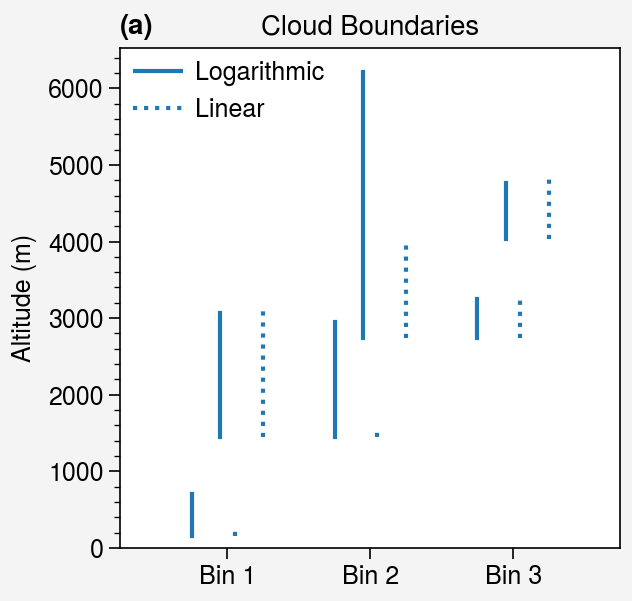

In [13]:
fig,ax=pplt.subplots(nrows=1,ncols=1,share=False,grid=False,abc='(a)',abcloc='l')#, aspect='equal', grid=False)

# cloud boundaries
for idx_cloutald,color in enumerate(['tab:blue','tab:blue','tab:blue']): # 'tab:pink','tab:olive','tab:cyan'
    # ax[0].plot([idx_cloutald,idx_cloutald+.2],bot_bounds_lin[:,idx_cloutald],linestyle='-',color=color)#,label='Bin No. '+str(idx_cloutald+1))
    # ax[0].plot([idx_cloutald,idx_cloutald+.2],bot_bounds_lin[:,idx_cloutald]+hgt_bounds_log[:,idx_cloutald],linestyle='-',color=color)
    ax[0].plot([idx_cloutald,idx_cloutald],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[0,idx_cloutald]+hgt_bounds_log[0,idx_cloutald]],linestyle='-',color=color)
    # ax[0].plot([idx_cloutald+.1,idx_cloutald+.1],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_log[1,idx_cloutald]],linestyle='-',color=color)
    ax[0].plot([idx_cloutald+.2,idx_cloutald+.2],[bot_bounds_lin[1,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_log[1,idx_cloutald]],linestyle='-',color=color)

    # ax[0].plot([idx_cloutald+.3,idx_cloutald+.5],bot_bounds_lin[:,idx_cloutald],linestyle=':',color=color)
    # ax[0].plot([idx_cloutald+.3,idx_cloutald+.5],bot_bounds_lin[:,idx_cloutald]+hgt_bounds_lin[:,idx_cloutald],linestyle=':',color=color)
    ax[0].plot([idx_cloutald+.3,idx_cloutald+.3],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[0,idx_cloutald]+hgt_bounds_lin[0,idx_cloutald]],linestyle=':',color=color)
    # ax[0].plot([idx_cloutald+.4,idx_cloutald+.4],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_lin[1,idx_cloutald]],linestyle=':',color=color)
    ax[0].plot([idx_cloutald+.5,idx_cloutald+.5],[bot_bounds_lin[1,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_lin[1,idx_cloutald]],linestyle=':',color=color)
ax[0].plot([-10,-10],[0,0],color='tab:blue',linestyle='-',label='Logarithmic')
ax[0].plot([-10,-10],[0,0],color='tab:blue',linestyle=':',label='Linear')
ax[0].legend(frame=False,loc='ul',ncol=1)
ax[0].format(xlim=(-0.5,3),xlocator=[.25,1.25,2.25],xtickminor=False,xticklabels=['Bin 1','Bin 2','Bin 3'],#,xlocator=[.1,.4,1.1,1.4,2.1,2.4],xtickminor=False,xticklabels=['Log','Lin','Log','Lin','Log','Lin'],xlabel='Distribution Type',
             ylabel='Altitude (m)',ylim=0,
             title='Cloud Boundaries')

pplt.show()

In [14]:
# fig,ax=pplt.subplots(nrows=1,ncols=2,share=False,grid=False,abc='(a)',abcloc='l')#, aspect='equal', grid=False)

# # cloud boundaries
# for idx_cloutald,color in enumerate(['tab:blue','tab:blue','tab:blue']): # 'tab:pink','tab:olive','tab:cyan'
#     ax[1].plot([idx_cloutald,idx_cloutald+.2],bot_bounds_lin[:,idx_cloutald],linestyle='-',color=color)#,label='Bin No. '+str(idx_cloutald+1))
#     ax[1].plot([idx_cloutald,idx_cloutald+.2],bot_bounds_lin[:,idx_cloutald]+hgt_bounds_log[:,idx_cloutald],linestyle='-',color=color)
#     ax[1].plot([idx_cloutald,idx_cloutald],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[0,idx_cloutald]+hgt_bounds_log[0,idx_cloutald]],linestyle='-',color=color)
#     ax[1].plot([idx_cloutald+.2,idx_cloutald+.2],[bot_bounds_lin[1,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_log[1,idx_cloutald]],linestyle='-',color=color)

#     ax[1].plot([idx_cloutald+.3,idx_cloutald+.5],bot_bounds_lin[:,idx_cloutald],linestyle=':',color=color)
#     ax[1].plot([idx_cloutald+.3,idx_cloutald+.5],bot_bounds_lin[:,idx_cloutald]+hgt_bounds_lin[:,idx_cloutald],linestyle=':',color=color)
#     ax[1].plot([idx_cloutald+.3,idx_cloutald+.3],[bot_bounds_lin[0,idx_cloutald],bot_bounds_lin[0,idx_cloutald]+hgt_bounds_lin[0,idx_cloutald]],linestyle=':',color=color)
#     ax[1].plot([idx_cloutald+.5,idx_cloutald+.5],[bot_bounds_lin[1,idx_cloutald],bot_bounds_lin[1,idx_cloutald]+hgt_bounds_lin[1,idx_cloutald]],linestyle=':',color=color)
# ax[1].plot([-10,-10],[0,0],color='tab:blue',linestyle='-',label='Logarithmic')
# ax[1].plot([-10,-10],[0,0],color='tab:blue',linestyle=':',label='Linear')
# ax[1].legend(frame=False,loc='ul',ncol=1)
# ax[1].format(xlim=(-0.5,3),xlocator=[.25,1.25,2.25],xtickminor=False,xticklabels=['Bin 1','Bin 2','Bin 3'],#,xlocator=[.1,.4,1.1,1.4,2.1,2.4],xtickminor=False,xticklabels=['Log','Lin','Log','Lin','Log','Lin'],xlabel='Distribution Type',
#              ylabel='Altitude (m)',ylim=0,
#              title='Cloud Boundaries')

# # y_fit,__,model_str,r2_str = lbf(dmv,eff)
# y_fit,__,model_str,r2_str = lbf(np.log(dmv),np.log(eff))
# small_dmv = (dmv<0.04) & (eff>y_fit)
# small_eff = (eff<10) & (eff<y_fit)
# kde = gaussian_kde(np.vstack([dmv,eff]))
# density=kde(np.vstack([dmv,eff]))
# import matplotlib
# # im=ax[0].scatter(dmv,eff,s=5,c=density,cmap='YlGnBu',a=.8,extend='max',norm=matplotlib.colors.LogNorm(),vmin=0.001,vmax=2) # 
# im=ax[0].scatter(np.log(dmv),np.log(eff),s=5,c=density,cmap='YlGnBu',a=.8,extend='max') # ,norm=matplotlib.colors.LogNorm(),vmin=0.001,vmax=2) # 
# # ax[0].axhline(eff_bounds_array[3],color='tab:grey',linestyle=':')#,zorder=2)
# # ax[0].axvline(dmv_bounds_array[3],color='tab:grey',linestyle=':')#,zorder=2)
# ax[0].plot(np.log(dmv),y_fit,color='black',label=model_str+'\n'+'r$^{2}$='+r2_str,linewidth=1,linestyle='-',zorder=2)
# # ax[0].scatter(dmv_bounds_array,eff_bounds_array,s=15,zorder=3,color='black')
# # ax[0].format(ylabel='r$_{eff}$ ($\mu$m)',xlabel='D$_{mv}$ (cm)',ylim=0,xlim=0)
# ax[0].legend(frame=True)
# ax[0].colorbar(im)

# if savefig:
#     fig.savefig('fig03_histogram_dimensions'+fig_extension)
#     pplt.close()
# else:
#     pplt.show()

### FIGURE 2,S1 - CLOUD AMOUNT HISTOGRAM
---

In [15]:
# fig,axs = pplt.subplots(nrows=4,ncols=4,grid=True,abc='(a)',abcloc='l')
# # PLOT ANNUAL AVERAGE CLOUD AMOUNT HISTOGRAM FOR EACH SLF BIN
# for midx,m in enumerate(slf_str[:-1]):
#     im = plot_histogram_panel(axs[midx],cloud_amount_annual[midx,:,:],0,5,'Reds',
#                               slf_str[midx]+'<SLF<'+slf_str[midx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_amount_annual[midx,:,:])))+'%',
#                               'Mixed-Phase Stratiform Cloud Amount',
#                               'D$_{mv}$ (cm)','TWP (kg m$^{-2}$)',dmv_str,twp_str)
# # PLOT CLOUD AMOUNT HISTOGRAM FOR EACH MONTH FOR ONE SLF BIN
# for midx,m in enumerate(list(month_str.keys())):
#     im = plot_histogram_panel(axs[midx+4],cloud_amount_monthly_annual_mean[midx,sidx,:,:],0,5,'Reds',
#                               month_str[m]+' | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_amount_monthly_annual_mean[midx,sidx,:,:])))+'%',
#                               'Mixed-Phase Stratiform Cloud Amount',
#                               'D$_{mv}$ (cm)','TWP (kg m$^{-2}$)',dmv_str,twp_str)
# # SAVE PLOT
# fig.colorbar(im,label='Mixed-Phase Stratiform Cloud Amount (%)')
# if savefig:
#     fig.savefig('fig02_cloud_amount_average_histogram_'+savename_bot_bound+'.jpg')
#     pplt.close()
# else:
#     pplt.show()

fig = pplt.figure()
axs = fig.subplots(
    [[1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5],[6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9],[10,10,10,10,10,11,11,11,11,11,12,12,12,12,12,13,13,13,13,13],[14,14,14,14,14,15,15,15,15,15,16,16,16,16,16,17,17,17,17,17]],
    grid=True,abc='(a)',abcloc='l',
)
# PLOT ANNUAL AVERAGE CLOUD AMOUNT HISTOGRAM FOR EACH SLF BIN
for midx,m in enumerate(slf_str[:-1]):
    im = plot_histogram_panel(axs[midx],cloud_amount_annual[midx,:,:],0,5,'Reds',
                              slf_str[midx]+'<SLF<'+slf_str[midx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_amount_annual[midx,:,:])))+'%',
                              'Mixed-Phase Stratiform Cloud Amount Histogram',
                              'D$_{mv}$ (cm)','TWP (g m$^{-2}$)',dmv_str,twp_str)
# PLOT CLOUD AMOUNT HISTOGRAM FOR EACH MONTH FOR ONE SLF BIN
for midx,m in enumerate(list(month_str.keys())):
    im = plot_histogram_panel(axs[midx+5],cloud_amount_monthly_annual_mean[midx,sidx,:,:],0,5,'Reds',
                              month_str[m]+' | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_amount_monthly_annual_mean[midx,sidx,:,:])))+'%',
                              'Mixed-Phase Stratiform Cloud Amount',
                              'D$_{mv}$ (cm)','TWP (g m$^{-2}$)',dmv_str,twp_str)
# SAVE PLOT
fig.colorbar(im,label='Mixed-Phase Stratiform Cloud Amount (%)')
if savefig:
    fig.savefig('fig02_cloud_amount_average_histogram_'+savename_bot_bound+'.jpg')
    pplt.close()
else:
    pplt.show()

In [16]:
fig,axs = pplt.subplots(nrows=3,ncols=4,grid=True,abc='(a)',abcloc='l')
# PLOT ANNUAL AVERAGE CLOUD AMOUNT HISTOGRAM FOR EACH SLF BIN
# for midx,m in enumerate(slf_str[:-1]):
#     im = plot_histogram_panel(axs[midx],cloud_anomaly_annual[midx,:,:],-.2,.2,'RdBu_r',
#                               slf_str[midx]+'<SLF<'+slf_str[midx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_anomaly_annual[midx,:,:])))+'%',
#                               'Mixed-Phase Stratiform Cloud Amount',
#                               'D$_{mv}$ (cm)','TWP (kg m$^{-2}$)',dmv_str,twp_str)
# PLOT CLOUD AMOUNT HISTOGRAM FOR EACH MONTH FOR ONE SLF BIN
for midx,m in enumerate(list(month_str.keys())):
    im = plot_histogram_panel(axs[midx],cloud_anomaly_monthly_annual_mean[midx,sidx,:,:],-2,2,'RdBu_r',
                              month_str[m]+' | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1]+'\nC$_{strat}$='+str(np.round(np.nansum(cloud_anomaly_monthly_annual_mean[midx,sidx,:,:])))+'%',
                              'Mixed-Phase Stratiform Cloud Amount',
                              'D$_{mv}$ (cm)','TWP (g m$^{-2}$)',dmv_str,twp_str)
# SAVE PLOT
fig.colorbar(im,label='Mixed-Phase Stratiform Cloud Amount (%)')
if savefig:
    fig.savefig('figS01_cloud_anomaly_average_histogram_'+savename_bot_bound+'.jpg')
    pplt.close()
else:
    pplt.show()

### FIGURE 3,S2-S3,S6-S8 - CLOUD RADIATIVE KERNELS
---

In [17]:
for ssidx,(sfc,krn_title,save_title,vmax) in enumerate(zip([sfc_lw,sfc_sw,sfc_net,toa_lw,toa_sw,toa_net],['Surface LW','Surface SW','Surface Net','TOA LW','TOA SW','TOA Net'],['S02','S03','03','S06','S07','S08'],[1,3,3,1,3,3])):
    # vmax = np.nanmax(np.abs(sfc))
    vmin = vmax*-1
    fig,axs = pplt.subplots(nrows=3,ncols=4,grid=False,abc='(a)',abcloc='l')
    for midx,m in enumerate(list(month_str.keys())):
        im = plot_histogram_panel(axs[midx],sfc[midx,sidx,:,:],vmin,vmax,'RdBu_r',
                                'Month: '+str(m),
                                krn_title+' Cloud Radiative Kernel | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1],
                                # krn_title+' Cloud Radiative Kernel\nCloud Base: '+str(cloud_bot)+' m | Cloud Depth: '+str(cloud_hgt)+' m'+' | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1],
                                'D$_{mv}$ (cm)','TWP (kg m$^{-2}$)',dmv_str,twp_str)
        # for ii in range(sfc[midx,sidx,:,:].shape[0]):
        #     for jj in range(sfc[midx,sidx,:,:].shape[1]):
        #         axs[midx].text(jj, ii, f'{sfc[midx,sidx,:,:][ii, jj]:.1f}', ha='center', va='center')#, color='tab:grey')# if sfc[midx,sidx,:,:][ii, jj] < .25*vmax else 'black')

    fig.colorbar(im,label='Cloud Radiative Kernel (W  m$^{-2}$ %$^{-1}$)')
    if savefig:
        fig.savefig('fig'+save_title+'_cloud_radiative_kernel_'+krn_title.replace(" ", "_").lower()+'_'+savename_bot_bound+'.jpg')
        pplt.close()
    else:
        pplt.show()

# fig,axs = pplt.subplots(nrows=6,ncols=6,grid=False,abc='(a)',abcloc='l')
# count=0
# for ssidx,(sfc,krn_title,save_title) in enumerate(zip([toa_lw,toa_sw,toa_net],['f$_{LW}$','f$_{SW}$','f$_{Net}$'],[(1,2),(3,4),(5,6)])):
#     vmax = np.nanmax(np.abs(sfc))
#     vmin = vmax*-1
#     for midx,m in enumerate(list(month_str.keys())):
#         im = plot_histogram_panel(axs[count],sfc[midx,sidx,:,:],vmin,vmax,'RdBu_r',
#                                 krn_title+' | Month: '+str(m),
#                                 'TOA Cloud Radiative Kernel\nCloud Base: '+str(kernel_cloud_bot)+' m | Cloud Depth: '+str(kernel_cloud_hgt)+' m'+' | '+slf_str[sidx]+'<SLF<'+slf_str[sidx+1],
#                                 'D$_{mv}$ (cm)','TWP (kg m$^{-2}$)',dmv_str,twp_str)
#         count+=1
#     fig.colorbar(im,rows=save_title,title=krn_title+' (W  m$^{-2}$ %$^{-1}$)') # ,label='Cloud Radiative Kernel (W  m$^{-2}$ %$^{-1}$)')
# if savefig:
#     fig.savefig('fig'+save_title+'_cloud_radiative_kernel_'+krn_title++fig_extension)
#     pplt.close()
# else:
#     pplt.show()

### FIGURE 5,S5 - DECOMPOSED CLOUD FEEDBACK
---

In [18]:
colors=['black','tab:blue','tab:orange','tab:green','tab:red','tab:grey']
fbk_labels=['f$_{tot}$','f$_{amt}$','f$_{slf}$','f$_{twp}$','f$_{dmv}$','f$_{res}$']
for (feedbacks,fluxes,titles,snames) in zip([[lw_fbk,sw_fbk,nt_fbk],[lw_fbk_toa,sw_fbk_toa,nt_fbk_toa]],[['LW','SW','Net'],['LW','SW','Net']],['Surface','TOA'],['04','S05']):
    fig,axs = pplt.subplots(nrows=2,ncols=3,grid=False,sharex=False,sharey=False,abc='(a)',abcloc='ul')
    for idx,(fbk,flux) in enumerate(zip(feedbacks,fluxes)):
        title=flux+' '+titles+' Cloud Feedback'
        axs[0,idx].axhline(0,color='black',linestyle='-',zorder=0)
        axs[1,idx].axhline(0,color='black',linestyle='-',zorder=0)
        for ridx,(var,col,lab) in enumerate(zip(list(fbk.keys()),colors,fbk_labels)):
            # print(flux,lab,fbk[var].values)
            plot_bar(axs[1,idx],ridx,0.5,np.nanmean(fbk[var].values),col)
            if ridx==5:
                axs[0,idx].plot(np.arange(1,13),fbk[var].values,color=col,marker='o',facecolor='none',linestyle=':',label=lab)
                axs[0,idx].scatter(13,np.nanmean(fbk[var].values)*10,facecolor='none',edgecolor=col)
            else:
                # print(lab,fbk[var].values>0)
                axs[0,idx].plot(np.arange(1,13),fbk[var].values,color=col,marker='o',linestyle='-',label=lab)
                axs[0,idx].scatter(13,np.nanmean(fbk[var].values)*10,color=col)
        for midx in [2.5,5.5,8.5,11.5]:
            axs[0,idx].axvline(midx,color='tab:grey',linestyle='--')
        axs[0,idx].axvline(12.5,color='tab:grey',linestyle=':')
        axs[0,idx].format(
                ylim=(-7,7), 
                xlim=(0.5,13.5),xlocator=np.arange(1,14),xtickminor=False,xticklabels=['J','F','M','A','M','J','J','A','S','O','N','D','Avg\n(x10)'],
                title=title,suptitle='North Slope Alaska',
                ylabel='Feedback (Wm$^{-2}$K$^{-1}$)'
                )
        axs[1,idx].format(
                ylim=(-.7,.7), 
                xlim=(-0.1,5.6),xlocator=np.arange(6)+.25,xtickminor=False,xticklabels=fbk_labels, # ,xrotation=90
                ylabel='Feedback (Wm$^{-2}$K$^{-1}$)')
    axs[0,2].legend(loc='r',frame=False,ncol=1)
    
    if savefig:
        fig.savefig('fig'+snames+'_'+titles.lower()+'_cloud_feedback_components_'+savename_bot_bound+fig_extension)
        pplt.close()
    else:
        pplt.show()

### FIGURE 6 - CLOUD HISTOGRAM SUMS
---

In [19]:
month_lwfbk = np.ones((5,12))*np.nan
month_swfbk = np.ones((5,12))*np.nan
month_ntfbk = np.ones((5,12))*np.nan
for vidx,var in enumerate(['dR_sum', 'dR_prop', 'dR_dslf', 'dR_dtwp', 'dR_ddmv']):
    month_lwfbk[vidx,:] = lw_fbk[var].values
    month_swfbk[vidx,:] = sw_fbk[var].values
    month_ntfbk[vidx,:] = nt_fbk[var].values

month_lwfbk = month_lwfbk/np.nanmax(np.abs(month_lwfbk))
month_swfbk = month_swfbk/np.nanmax(np.abs(month_swfbk))
month_ntfbk = month_ntfbk/np.nanmax(np.abs(month_ntfbk))

sums_amt = np.ones((1,12))*np.nan
sums_slf = np.ones((5,12))*np.nan
sums_twp = np.ones((5,12))*np.nan
sums_dmv = np.ones((5,12))*np.nan
sums_amt[0,:12] = np.nansum(cloud_anomaly_monthly_annual_mean[:,:,:,:],axis=(1,2,3))

for sumidx in range(5):
    sums_slf[sumidx,:12] = np.nansum(cloud_anomaly_monthly_annual_mean[:,sumidx,:,:],axis=(1,2))
    sums_twp[sumidx,:12] = np.nansum(cloud_anomaly_monthly_annual_mean[:,:,sumidx,:],axis=(1,2))
    sums_dmv[sumidx,:12] = np.nansum(cloud_anomaly_monthly_annual_mean[:,:,:,sumidx],axis=(1,2))

sums_amt = sums_amt/np.nanmax(np.abs(sums_amt))
sums_slf = sums_slf/np.nanmax(np.abs(sums_slf))
sums_twp = sums_twp/np.nanmax(np.abs(sums_twp))
sums_dmv = sums_dmv/np.nanmax(np.abs(sums_dmv))

fig = pplt.figure(share=False,)
axs = fig.subplots(
    [[1,1,2,2,3,3],[0,4,4,5,5,0],[6,6,7,7,8,8]],
    grid=False,abc='(a)',abcloc='l',
)

# histogram sums
axs[0].imshow(sums_slf,vmin=-1,vmax=1,cmap='RdBu_r',origin='lower',extend='both')
axs[1].imshow(sums_twp,vmin=-1,vmax=1,cmap='RdBu_r',origin='lower',extend='both')
axs[2].imshow(sums_dmv,vmin=-1,vmax=1,cmap='RdBu_r',origin='lower',extend='both')

axs[0].format(title='$\Sigma_{td}\Delta$C',ylocator=np.arange(7)-.5,yticklabels=slf_str,xlocator=np.arange(12),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12'],ytickminor=False,xtickminor=False,xlabel='Month',ylabel='SLF')
axs[1].format(title='$\Sigma_{sd}\Delta$C',ylocator=np.arange(7)-.5,yticklabels=twp_str,xlocator=np.arange(12),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12'],ytickminor=False,xtickminor=False,xlabel='Month',ylabel='TWP (g m$^{-2}$)')
axs[2].format(title='$\Sigma_{st}\Delta$C',ylocator=np.arange(7)-.5,yticklabels=dmv_str,xlocator=np.arange(12),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12'],ytickminor=False,xtickminor=False,xlabel='Month',ylabel='D$_{mv}$ (cm)')

im=axs[3].imshow(sums_amt,vmin=-1,vmax=1,cmap='RdBu_r',origin='lower',extend='both')
im=axs[4].imshow((temp_anomaly.squeeze()/np.nanmax(np.abs(temp_anomaly.squeeze())))[np.newaxis,...],vmin=-1,vmax=1,cmap='RdBu_r',origin='lower',extend='both')
axs[3].format(title='$\Sigma_{std}\Delta$C',yticks=[],xlocator=np.arange(12),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12'],ytickminor=False,xtickminor=False)
axs[4].format(title='$\Delta$T',yticks=[],xlocator=np.arange(12),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12'],ytickminor=False,xtickminor=False)

fig.colorbar(im,rows=(1,2))

for axhline in np.arange(0.5,5):
    for axidx in range(3):
        axs[axidx].axhline(axhline,color='tab:grey')


ds = xr.open_dataset('../data/DOE_ARM_NSA_cloud_dataset_20002020.nc')
ds_mean = ds.resample(time='MS').mean('time').groupby('time.month').mean()
ds_month_anom = ds.groupby('time.month')-ds_mean
for idx,(variable,bins,xlabel) in enumerate(zip(['slf_avglayer','twp_avglayer','dmv_avg_gcpex'],[np.arange(-1,1.25,.25),np.arange(-500,6500,500),np.arange(-.05,.15,.025)],['SLF','TWP g m$^{-2}$','D$_{mv}$ ($\mu$m)'])):
    axs[idx+5].hist(ds_month_anom[variable].values,bins=bins)
    axs[idx+5].axvline(color='tab:grey',linestyle=':')
    axs[idx+5].format(suptitle='Monthly Anomaly',xlabel=xlabel,ylabel='No. of Hours')

if savefig:
    fig.savefig('fig05_monthly_summaries_'+savename_bot_bound+'.jpg')
    pplt.close()
else:
    pplt.show()

### FIGURE S4 - HISTOGRAM AXIS VARIABLE TRENDS
---

In [20]:
fig,ax = pplt.subplots(nrows=2,ncols=2,share=False,grid=True,abc='(a)',abcloc='l')
for vidx,(var,title) in enumerate(zip(vars,['C','SLF','TWP','D$_{mv}$'])):
    im = ax[vidx].imshow(slopes_anom[var],origin='lower',extend='both',vmax=0.5,vmin=-0.5)
    for x in np.arange(13):
        for y in np.arange(2):
            if signif_anom[var][y,x] > 0.4:
                ax[vidx].scatter(x,y,marker='o',facecolor='tab:grey',edgecolor='white')
    ax[vidx].axvline(11.5,color='black')
    ax[vidx].format(
        suptitle='Anomaly Trend Slopes', title=title,
        ylocator=np.arange(2),yticklabels=['T$_{sfc}$','time'],ytickminor=False,
        xlocator=np.arange(13),xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12','Y'],xtickminor=False,
    )
fig.colorbar(im,loc='bottom',label='normalized slope')
if savefig:
    fig.savefig('figS04_temporal_temperature_trends_anomaly_'+savename_bot_bound+fig_extension)
    pplt.close()
else:
    pplt.show()

### FIGURE S - 3D HISTOGRAM DEPICTIONS
---

In [21]:
for hist,cmap,vmin,vmax,extend,savename in zip([cloud_amount_monthly_annual_mean,sfc_net,sfc_lw,sfc_sw],['Reds','RdBu_r','Reds','Blues_r'],[0,-3,0,-3],[5,3,1,0],['max','both','max','min'],['cloud_amount','surface_net_crk','surface_lw_crk','surface_sw_crk']):
    # month, slf, twp, dmv
    long_hist_slf = np.ones((60,len(slf_str[:-1])*5))
    long_hist_twp = np.ones((60,len(twp_str[:-1])*5))
    long_hist_dmv = np.ones((60,len(dmv_str[:-1])*5))
    for sidx,s in enumerate(slf_str[:-1]):
        sfive = 5*sidx
        for midx,m in enumerate(list(month_str.keys())):
            mfive = 5*midx
            long_hist_slf[mfive:mfive+5,sfive:sfive+5] = hist[-1-midx,sidx,:,:]
            long_hist_twp[mfive:mfive+5,sfive:sfive+5] = hist[-1-midx,:,sidx,:]
            long_hist_dmv[mfive:mfive+5,sfive:sfive+5] = hist[-1-midx,:,:,sidx]

    fig,axs = pplt.subplots(ncols=3,nrows=1,grid=False,share=False)#,abc='(a)',abcloc='l')

    im=axs[0].imshow(long_hist_slf,cmap=cmap,vmin=vmin,vmax=vmax,extend=extend,origin='lower')
    axs[0].format(
        xtickminor=False,xlocator=np.arange(2,25,5),xticklabels=['0.0<SLF<0.30','0.30<SLF<0.75','0.75<SLF<0.95','0.95<SLF<0.999','0.999<SLF<1.0'],xrotation=45,
        ytickminor=False,ylocator=np.arange(2,60,5),yticklabels=['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'][::-1],
        ylabel='TWP',xlabel='Dmv'
    )
    im=axs[1].imshow(long_hist_twp,cmap=cmap,vmin=vmin,vmax=vmax,extend=extend,origin='lower')
    axs[1].format(
        xtickminor=False,xlocator=np.arange(2,25,5),xticklabels=['0<TWP<27','27<TWP<58','58<TWP<105','105<TWP<180','180<TWP<2250',],xrotation=45,
        ytickminor=False,ylocator=np.arange(2,60,5),yticklabels=['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'][::-1],
        ylabel='SLF',xlabel='Dmv'
    )
    im=axs[2].imshow(long_hist_dmv,cmap=cmap,vmin=vmin,vmax=vmax,extend=extend,origin='lower')
    axs[2].format(
        xtickminor=False,xlocator=np.arange(2,25,5),xticklabels=['0.0<Dmv<0.026','0.026<Dmv<0.031','0.031<Dmv<0.042','0.042<Dmv<0.062','0.062<Dmv<0.145'],xrotation=45,
        ytickminor=False,ylocator=np.arange(2,60,5),yticklabels=['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'][::-1],
        ylabel='SLF',xlabel='TWP'
    )
    fig.colorbar(im,label='Mixed-Phase Stratiform Cloud Amount (%)')
    for idx in range(3):
        for sidx,s in enumerate(slf_str[:-1]):
            sfive = 5*sidx
            axs[idx].axvline(sfive-.5,color='grey')
        axs[idx].axvline(sfive+5-.5,color='grey')
        for midx,m in enumerate(list(month_str.keys())):
            mfive = 5*midx
            axs[idx].axhline(mfive-.5,color='grey')
        axs[idx].axhline(mfive+5-.5,color='grey')

    if savefig:
        fig.savefig('figS_all_histograms_'+savename+fig_extension)
        pplt.close()
    else:
        pplt.show()

fig,axs = pplt.subplots(ncols=3,nrows=4,grid=False,abc='(a)',abcloc='l',share=False) 
for idx2,(axissum,ylabel,yticklabels) in enumerate(zip([[2,3],[1,3],[1,2]],['SLF','TWP','D$_{mv}$'],[slf_str,twp_str,dmv_str])):
    im1=plot_histogram_panel(axs[0,idx2],np.nansum(cloud_amount_monthly_annual_mean,axis=(axissum[0],axissum[1])).T,0,40,'Reds','Total Cloud Amount','','Months',ylabel,['J','F','M','A','M','J','J','A','S','O','N','D'],yticklabels,True)
    axs[0,idx2].colorbar(im1,loc='right')
    im2=plot_histogram_panel(axs[1,idx2],np.nanmean(sfc_net,axis=(axissum[0],axissum[1])).T,-3,3,'RdBu_r', 'Average Surface K$_{Net}$','','Months',ylabel,['J','F','M','A','M','J','J','A','S','O','N','D'],yticklabels,True)
    axs[1,idx2].colorbar(im2,loc='right')
    im3=plot_histogram_panel(axs[2,idx2],np.nanmean(sfc_lw,axis=(axissum[0],axissum[1])).T , 0,1,'Reds',   'Average Surface K$_{LW}$','','Months',ylabel,['J','F','M','A','M','J','J','A','S','O','N','D'],yticklabels,True)
    axs[2,idx2].colorbar(im3,loc='right')
    im4=plot_histogram_panel(axs[3,idx2],np.nanmean(sfc_sw,axis=(axissum[0],axissum[1])).T ,-3,0,'Blues_r','Average Surface K$_{SW}$','','Months',ylabel,['J','F','M','A','M','J','J','A','S','O','N','D'],yticklabels,True)
    axs[3,idx2].colorbar(im4,loc='right')

for idx2 in range(12):
    for idx in np.arange(.5,11.5):
        axs[idx2].axvline(idx,color='grey3')
    for idx in np.arange(.5,4.5):
        axs[idx2].axhline(idx,color='grey3')

if savefig:
    fig.savefig('figS_all_histograms_sums_'+fig_extension)
    pplt.close()
else:
    pplt.show()


### FIGURE  - ANOMALY HISTOGRAMS
---

In [22]:
ds = xr.open_dataset('../data/DOE_ARM_NSA_cloud_dataset_20002020.nc')
ds_mean = ds.resample(time='MS').mean('time').groupby('time.month').mean()
ds_month_anom = ds.groupby('time.month')-ds_mean

fig,axs = pplt.subplots(nrows=1,ncols=3,share=False,grid=False,abc='(a)',abcloc='ul')
for idx,(variable,bins,xlabel) in enumerate(zip(['slf_avglayer','twp_avglayer','dmv_avg_gcpex'],[np.arange(-1,1.25,.25),np.arange(-500,6500,500),np.arange(-.05,.15,.025)],['SLF','TWP g m$^{-2}$','D$_{mv}$ ($\mu$m)'])):
    axs[idx].hist(ds_month_anom[variable].values,bins=bins)
    axs[idx].axvline(color='tab:grey',linestyle=':')
    axs[idx].format(suptitle='Monthly Anomaly',xlabel=xlabel,ylabel='No. of Hours')
if savefig:
    fig.savefig('fig_monthly_anom_histograms'+fig_extension)
    pplt.close()
else:
    pplt.show()

---

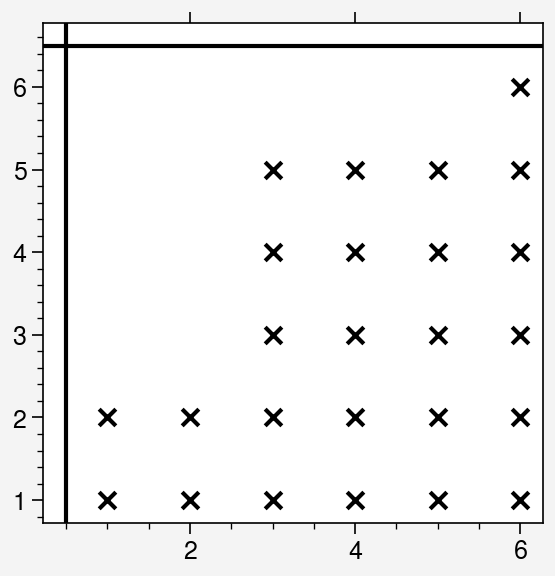

In [23]:
fig,ax=pplt.subplots(nrows=1,ncols=1,grid=False)
# ax.axis('o')
ax.scatter([1,2,3,4,5,6,1,2,3,4,5,6,3,4,5,6,3,4,5,6,3,4,5,6,6],[1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6],marker='x',color='black')
ax.axhline(6.5,color='black')
ax.axvline(0.5,color='black')
ax.tick_params(top=True)
pplt.show()


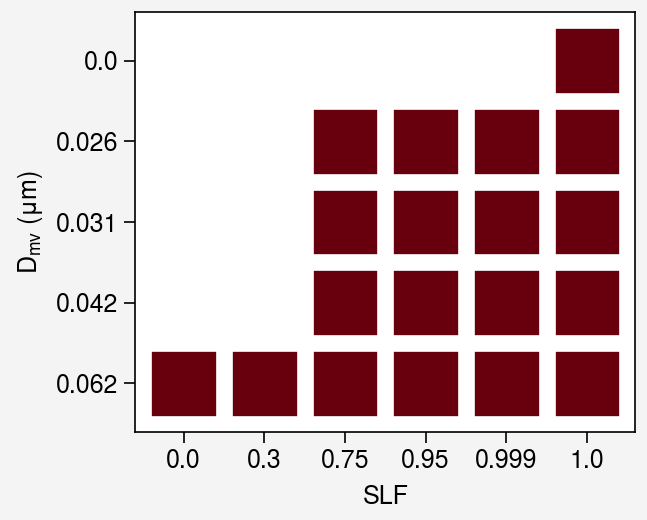

In [24]:
table = np.array([
    [np.nan,np.nan,np.nan,np.nan,np.nan,1],
    [np.nan,np.nan,1,1,1,1],
    [np.nan,np.nan,1,1,1,1],
    [np.nan,np.nan,1,1,1,1],
    [1,1,1,1,1,1],
    ])

fig,ax = pplt.subplots(nrows=1,ncols=1,grid=False)

ax.imshow(table,cmap='Reds',vmin=0,vmax=1)
for i in range(7):
    ax.axvline(i-.5,color='white',linewidth=6)
for i in range(6):
    ax.axhline(i-.5,color='white',linewidth=6)
ax.format(
    xlim=(-.6,5.6),xlocator=np.arange(0,6),xtickminor=False,xticklabels=['0.0','0.3','0.75','0.95','0.999','1.0'],xlabel='SLF',
    ylim=(4.6,-.6),ylocator=np.arange(0,5),ytickminor=False,yticklabels=['0.0','0.026','0.031','0.042','0.062','0.145'],ylabel='D$_{mv}$ ($\mu$m)'
          )
pplt.show()

---